In [ ]:
%pip install pyextremes

  Obtaining dependency information for pyextremes from https://files.pythonhosted.org/packages/76/17/f6eb9f3208f94999fa92a019852de27dacee45fd377aac3ef7d576df691a/pyextremes-2.3.3-py3-none-any.whl.metadata
  Obtaining dependency information for emcee<4.0.0,>=3.0.3 from https://files.pythonhosted.org/packages/f9/ef/2196b9bf88ffa1bde45853c72df021fbd07a8fa91a0f59a22d14a050dc04/emcee-3.1.6-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
   --------------------- ------------------ 30.7/57.6 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 57.6/57.6 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/47.4 kB ? eta -:--:--
   ---------------------------------------- 47.4/47.4 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed


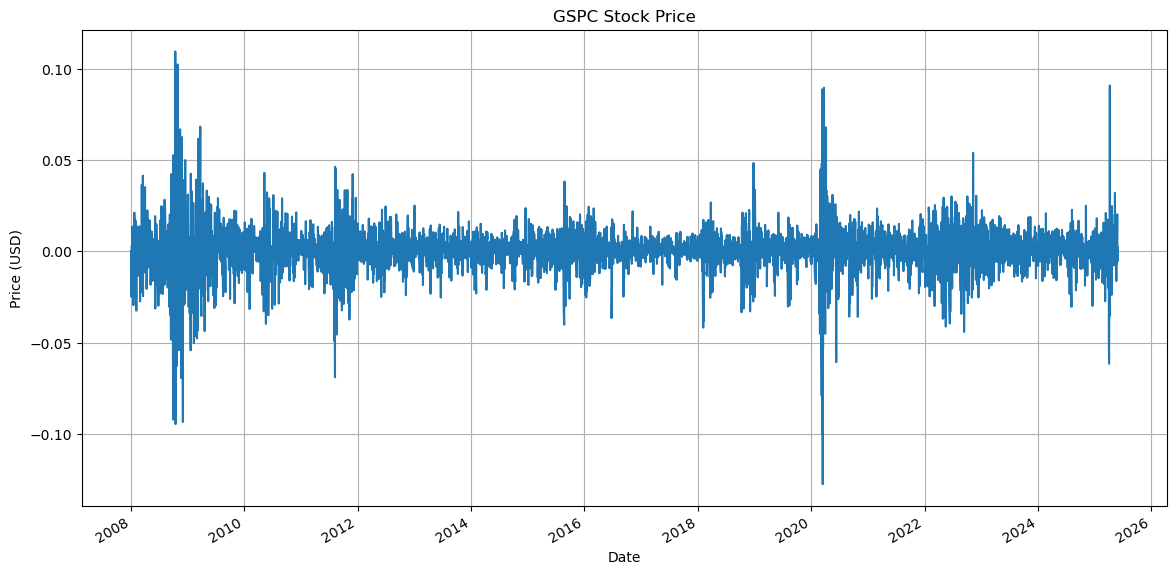

In [9]:
import yfinance as yf
import numpy as np
import pyextremes as pyx
import matplotlib.pyplot as plt

ticker="^GSPC"

data = yf.download(ticker, start="2008-01-01")['Close'] #S&P 500
log_returns = np.log(data / data.shift(1)).dropna()

log_returns[ticker].plot(title='GSPC Stock Price', figsize=(14, 7))
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid()
plt.show()


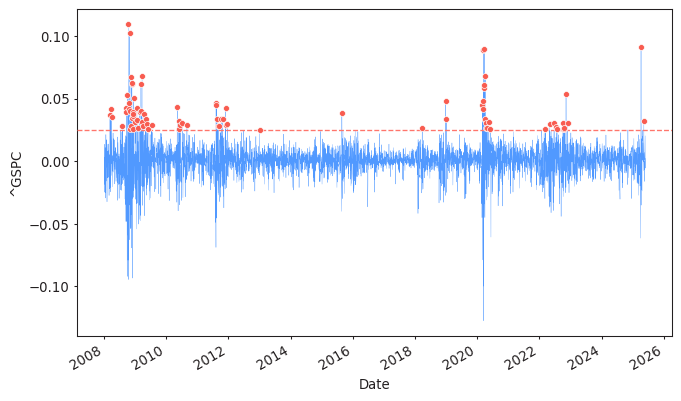

In [15]:
losses = -log_returns[log_returns['^GSPC'] < 0] #negative returns values
threshold = np.quantile(losses, 0.95) #0.95th quantile from data, crude
extreme_values = losses[losses > threshold] - threshold

def block_maxima_approach(ticker, data): #data pandas dataframe
    extremes = pyx.get_extremes(data[ticker], "BM")
    pyx.plotting.plot_extremes(
        ts=data,
        extremes=extremes,
        extremes_method="BM",
        extremes_type="high",
        block_size="365.2425D" #arbitrary block size of 1 year
    )
    plt.show()

def peaks_over_threshold(ticker, data, threshold):
    extremes = pyx.get_extremes(data[ticker], "POT", threshold=threshold, r="12h") #r: min time distance between adjacent clusters
    pyx.plotting.plot_extremes(
        ts=data[ticker],
        extremes=extremes,
        extremes_method="POT",
        extremes_type="high",
        threshold=threshold,
        r="12h",
    )
    plt.show()
    model = pyx.EVA(data=data[ticker])
peaks_over_threshold(ticker, log_returns, 0.025)

**How to choose threshold**

The return value is the value expected to be exceeded once in every N days. Good thresholds produce stable return values. Standard values of 10 and 100 days - expect 100 days to produce more extreme values but stabilise at a similar threshold to 10-day return values.

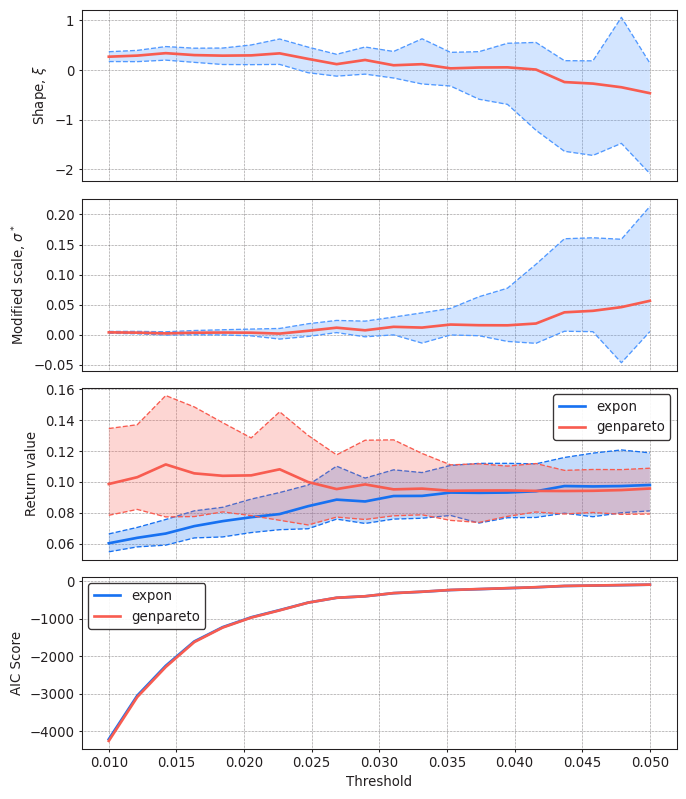

In [ ]:
pyx.plot_threshold_stability(log_returns[ticker], return_period=10, alpha=0.95, thresholds=np.linspace(0.01, 0.05, 20))
plt.show()
#threshold selection:0.025

Mean Residual Life Plot

<Axes: xlabel='Threshold', ylabel='Mean excess'>

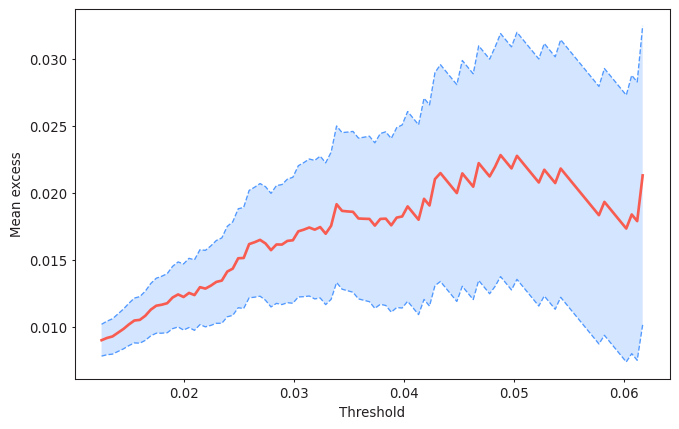

In [ ]:
pyx.plot_mean_residual_life(ts=log_returns['^GSPC'])
#0.025

Hill plot

[1.27652197e-01 9.99448524e-02 9.46951249e-02 ... 1.07398780e-05
 6.87014414e-06 5.83563519e-06]


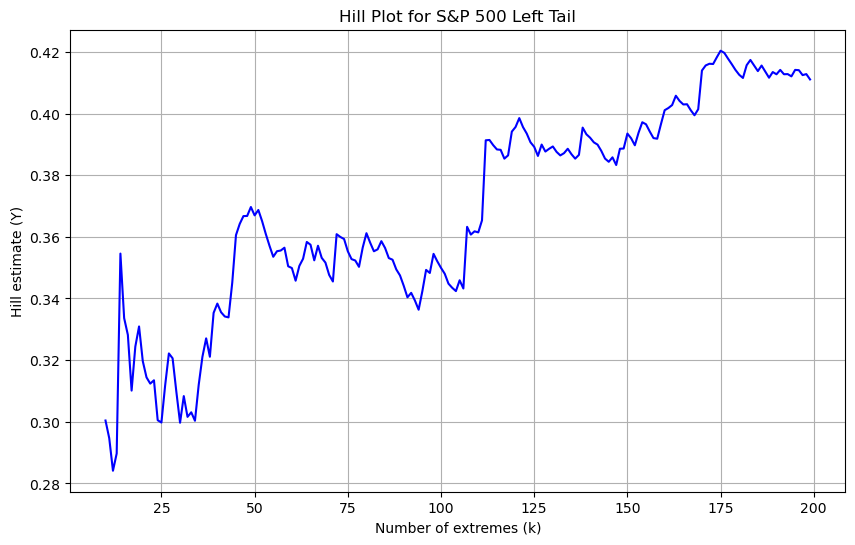

In [28]:
#sort log negative returns, descending order
neg_returns = -log_returns[log_returns['^GSPC'] < 0]
sorted_returns = np.sort(neg_returns['^GSPC'])[::-1]

print(sorted_returns)

def hill_estimator(data, k):
    log_data = np.log(data[:k])
    return (1/k) * np.sum(log_data) - np.log(data[k])

hill_estimates = [hill_estimator(sorted_returns, k) for k in range(10,200)]

plt.figure(figsize=(10,6))
plt.plot(range(10,200), hill_estimates, 'b-')
plt.xlabel('Number of extremes (k)')
plt.ylabel('Hill estimate (Y)')
plt.title('Hill Plot for S&P 500 Left Tail')
plt.grid(True)
plt.show()



Hill plots plot a graph of the estimates of the tail index as a function of the cut-off k. Regions
of the plot that are approximately close to be horizontal lines indicate values of k for which the
estimate $\hat{\alpha}_{k,n}^{H}$ is essentially stable with respect to the choice of the cut-off. In the above plot, stable region looks like region 60 to 85.

Pickands' plot

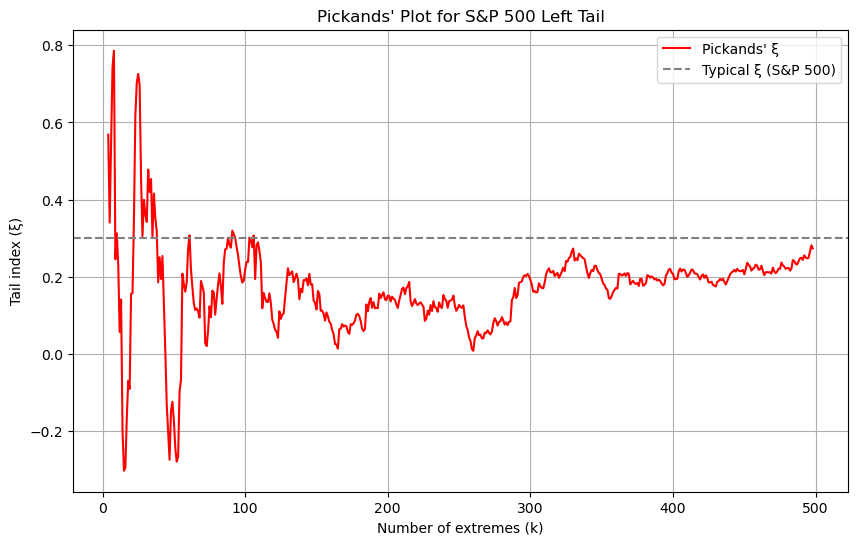

In [32]:
def pickands_estimator(data, k):
    if 4*k >= len(data):
        return np.nan
    return 1/np.log(2) * np.log((data[k] - data[2*k])/(data[2*k] - data[4*k]))

k_values = range(4, len(sorted_returns)//4)
pickands_estimates = [pickands_estimator(sorted_returns, k) for k in k_values]

plt.figure(figsize=(10,6))
plt.plot(k_values, pickands_estimates, 'r-', label="Pickands' ξ")
plt.axhline(0.3, color='gray', linestyle='--', label="Typical ξ (S&P 500)")
plt.xlabel("Number of extremes (k)")
plt.ylabel("Tail index (ξ)")
plt.title("Pickands' Plot for S&P 500 Left Tail")
plt.legend()
plt.grid(True)
plt.show()


Use the Pickands' plot to check Hill plot for stability in threshold choice range. Also gives an estimate for ξ parameter - around 0.15 in this case.

Mean Excess Plot

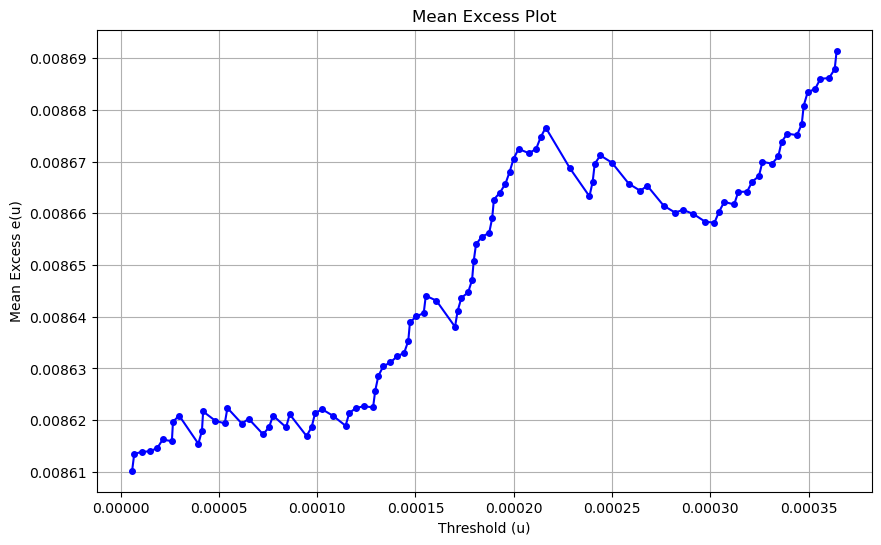

In [36]:
def mean_excess_plot(data, max_threshold_pct=0.05):
    data_sorted = np.sort(data)[::-1]  # Sort descending
    thresholds = np.quantile(data_sorted, np.linspace(0, max_threshold_pct, 100))
    e_u = []
    
    for u in thresholds:
        exceedances = data_sorted[data_sorted > u] - u
        e_u.append(np.mean(exceedances))
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, e_u, 'bo-', markersize=4)
    plt.xlabel("Threshold (u)")
    plt.ylabel("Mean Excess e(u)")
    plt.title("Mean Excess Plot")
    plt.grid(True)
    plt.show()

mean_excess_plot(neg_returns)

If the data have
an excess distribution over high thresholds which is distributed according to a GPD, then the
resulting plot will be roughly linear (for the higher order statistics) and the slope of the line will
provide evidence concerning the sign of the shape parameter ξ (an upward line corresponding
to ξ > 0, i.e. the Fréchet case; an horizontal plot, to ξ = 0; a downward plot, to ξ < 0).

Double Bootstrap method


Estimating return period

In [57]:
return_periods = pyx.get_return_periods(
    ts=log_returns,
    extremes=pyx.get_extremes(ts=log_returns[ticker], method="BM", block_size="365.2425D"),
    extremes_method="BM",
    extremes_type="high",
    block_size="365.2425D",
    #return_period_size="365.2425D",
    plotting_position="weibull"
)

print(return_periods)

               ^GSPC  exceedance probability  return period
Date                                                       
2008-10-13  0.109572                0.052632      19.000000
2009-03-23  0.068366                0.210526       4.750000
2010-05-10  0.043035                0.421053       2.375000
2011-08-09  0.046317                0.368421       2.714286
2013-01-02  0.025086                0.578947       1.727273
2013-10-10  0.021596                0.894737       1.117647
2014-12-18  0.023731                0.736842       1.357143
2015-08-26  0.038291                0.473684       2.111111
2016-01-29  0.024459                0.684211       1.461538
2017-03-01  0.013581                0.947368       1.055556
2018-12-26  0.048403                0.315789       3.166667
2019-01-04  0.033759                0.526316       1.900000
2020-03-24  0.089683                0.157895       6.333333
2021-03-01  0.023512                0.789474       1.266667
2022-11-10  0.053953                0.26

Full S&P500 model

               return value  lower ci   upper ci
return period                                   
1.0                0.023276  0.019712   0.026925
2.0                0.034698  0.027223   0.044530
5.0                0.053274  0.039320   0.084191
10.0               0.072418  0.051466   0.154167
25.0               0.108078  0.069695   0.482441
50.0               0.146234  0.085409   1.186238
100.0              0.197972  0.104224   2.944226
250.0              0.295826  0.132578   9.849974
500.0              0.401202  0.157602  24.569427
1000.0             0.544449  0.189562  61.302380


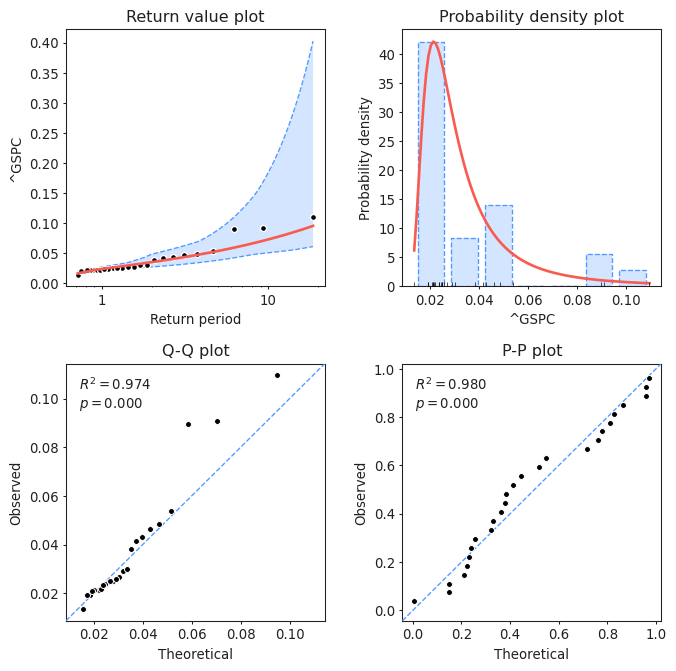

In [62]:
model = pyx.EVA(log_returns['^GSPC'])
model.get_extremes(method="BM", block_size="252D")
model.fit_model()
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)
print(summary)
model.plot_diagnostic(alpha=0.95)
plt.show()